In [1]:
import os
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential,Model
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from keras.utils import to_categorical
from joblib import dump, load

In [2]:
import sys, csv, codecs
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [3]:
import seaborn as sns
from matplotlib import style     
style.use("ggplot")
from nltk.util import pr
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer     
stopword = set(stopwords.words('english'))

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import string

In [4]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [5]:
data = pd.read_csv("labeled_data.csv")

In [6]:
data["labels"] = data["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive"})
print(data.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet                 labels  
0  !!! RT @mayasolovely: As a woman you shouldn't...  No Hate and Offensive  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...     Offensive Language  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...     Offensive Language  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...     Offensive Language  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     Offensive Language  


In [7]:
acc_summary = pd.DataFrame(columns=['Model', 'Accuracy'])

In [8]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [9]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [10]:
#applying pre-processing to text data
data.tweet=data['tweet'].apply(clean)

In [11]:
tweetData = data.drop_duplicates("tweet")

In [12]:
# to see updated number of columns as duplicates entries are removed
tweetData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24506 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24506 non-null  object
 1   labels  24506 non-null  object
dtypes: object(2)
memory usage: 574.4+ KB


In [13]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(word) for word in data]
    return data

In [14]:
#lemmatizing the processed dataa
tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))

C:\Users\yashp\AppData\Local\Temp\ipykernel_22116\1355919582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))


In [15]:
# to see distribution of labels
tweetData['labels'].value_counts()

labels
Offensive Language       18984
No Hate and Offensive     4113
Hate Speech               1409
Name: count, dtype: int64

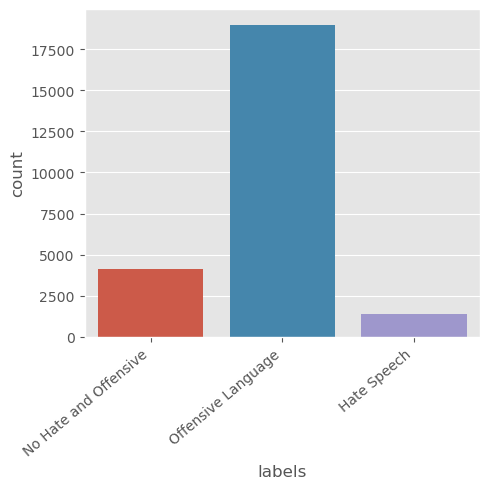

In [16]:
# to visualize the data using a count plot
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='labels', data=tweetData)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

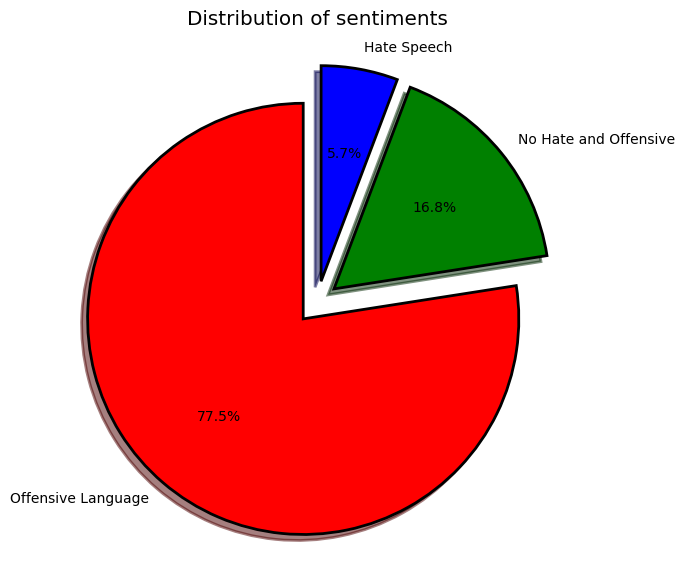

In [17]:
# visualizing data using piechart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = tweetData['labels'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

In [18]:
Off_hate_tweets = tweetData[tweetData.labels=='Offensive Language']

In [19]:
hate_tweets = tweetData[tweetData.labels=='Hate Speech']

In [20]:
non_hate_tweets = tweetData[tweetData.labels=='No Hate and Offensive']

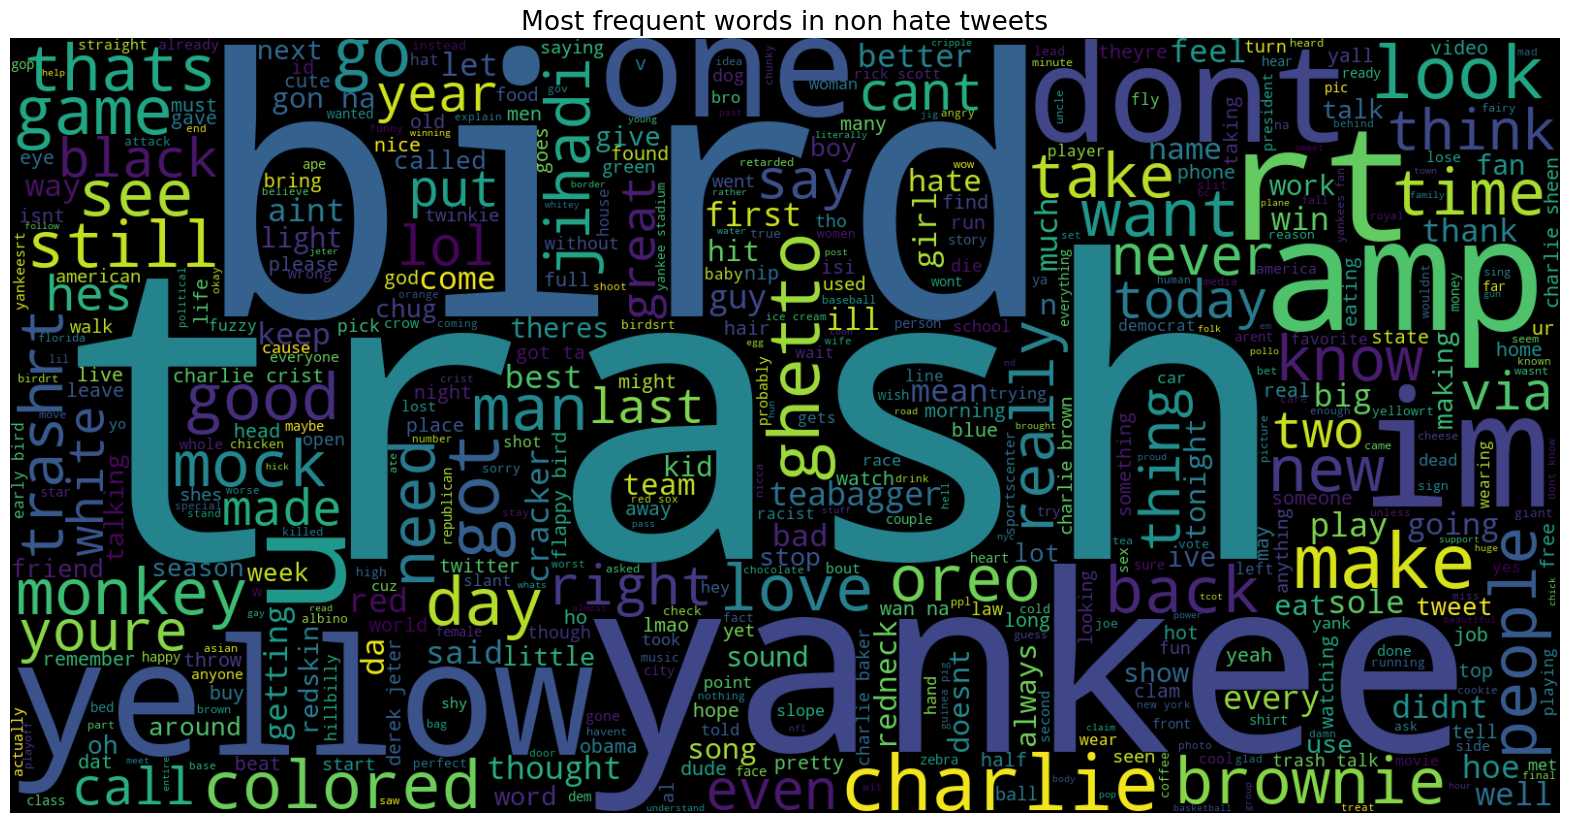

In [21]:
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

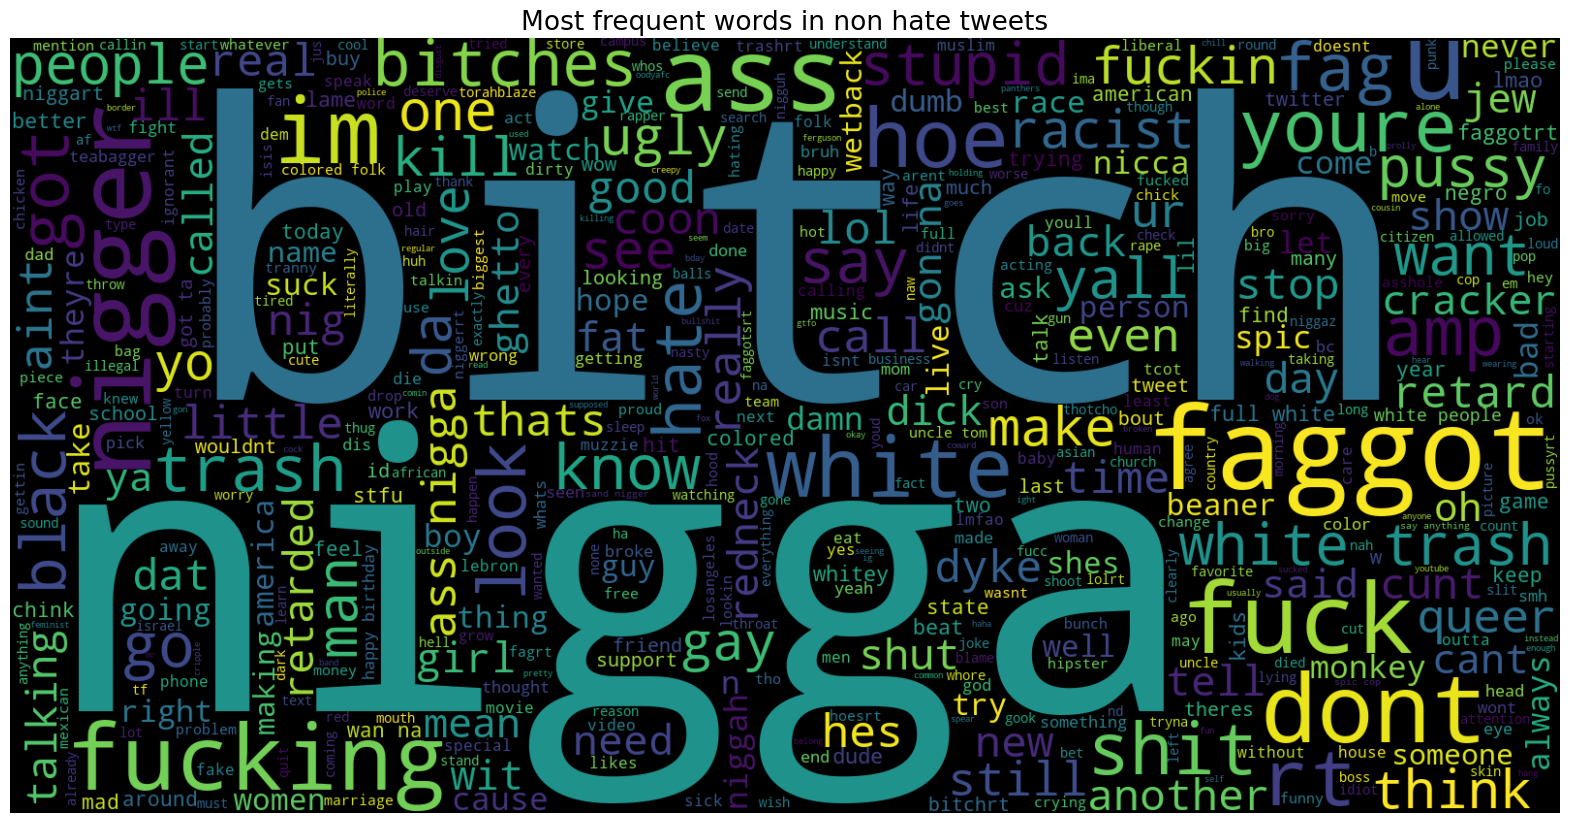

In [22]:
text=''.join([word for word in hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

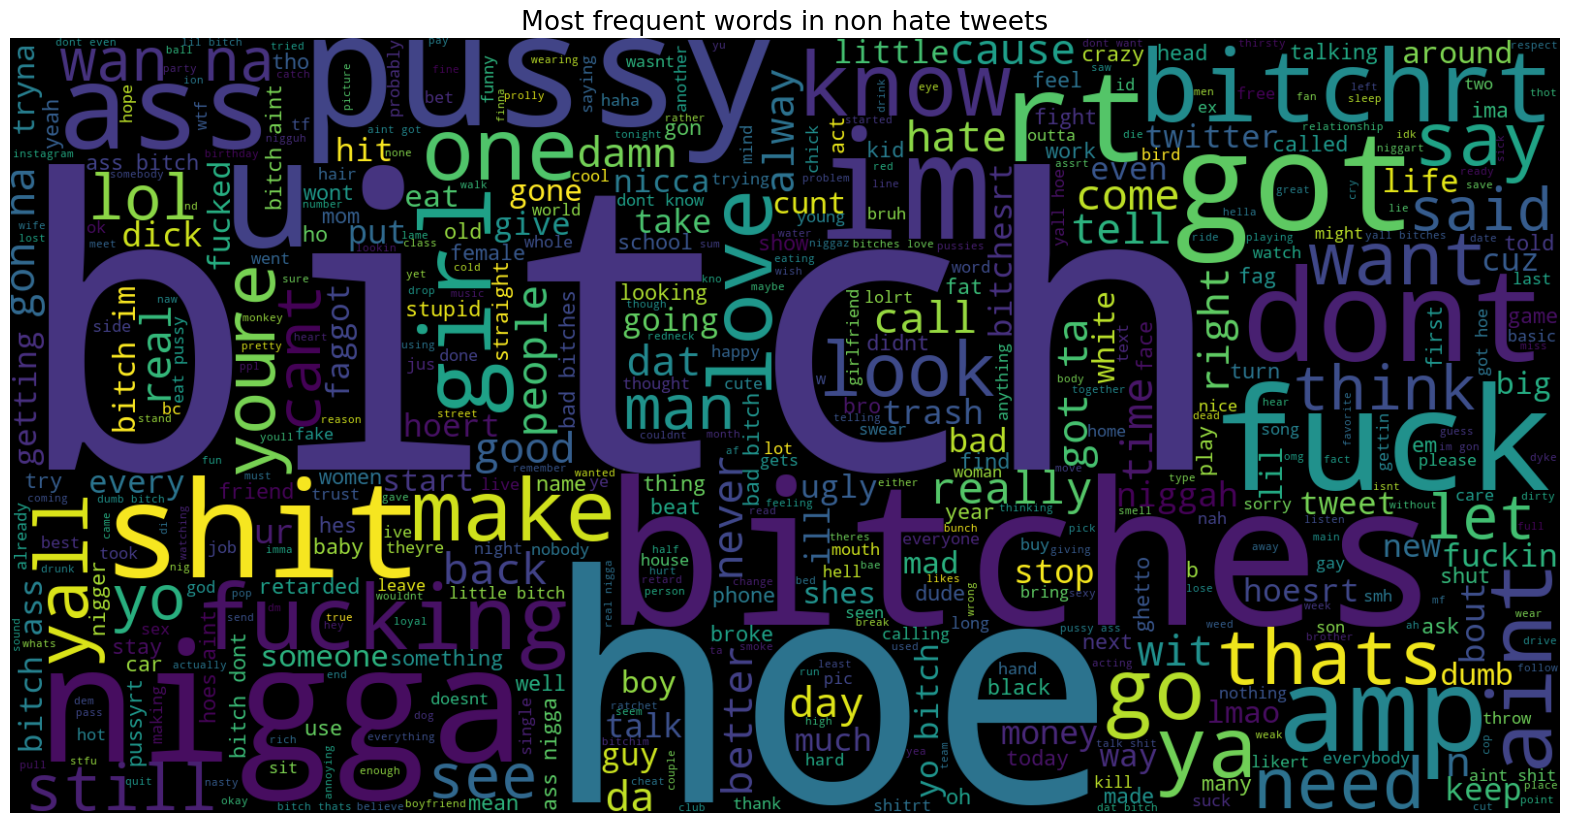

In [23]:
text=''.join([word for word in Off_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

In [24]:
vect=TfidfVectorizer(ngram_range=(1,3)).fit(tweetData['tweet'])

In [25]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:20]))

Number of features: {}
 310426
First 200 features: 
 ['aa' 'aa classes' 'aa classes bc' 'aa lol' 'aa lol gduenez' 'aaaaaaaaand'
 'aaaaaaaaand begins' 'aaaaaaaaand begins rt' 'aaahhhhh'
 'aaahhhhh internet' 'aaahhhhh internet died' 'aahahah' 'aahahah fuck'
 'aahahah fuck watches' 'aaliyah' 'aaliyah curving' 'aaliyah curving low'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhhm knowww righttt']


In [26]:
#separating the data into x and y to build the model
X = tweetData['tweet']
Y = tweetData['labels']
X = vect.transform(X) #transforming the x data

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

In [27]:
#for training the data on logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_resampled, y_train_resampled) #loading x_train and y_train data on model
logreg_predict = logreg.predict(X_test) #predicting the value for test data
logreg_acc = accuracy_score(logreg_predict,Y_test)

C:\Users\yashp\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 88.98%


In [29]:
#printing confusion matrix and classification report
print(confusion_matrix(Y_test, logreg_predict))
print("\n")
print(classification_report(Y_test, logreg_predict))

[[  94   33  156]
 [   6  716   86]
 [  95  164 3552]]


                       precision    recall  f1-score   support

          Hate Speech       0.48      0.33      0.39       283
No Hate and Offensive       0.78      0.89      0.83       808
   Offensive Language       0.94      0.93      0.93      3811

             accuracy                           0.89      4902
            macro avg       0.73      0.72      0.72      4902
         weighted avg       0.88      0.89      0.89      4902



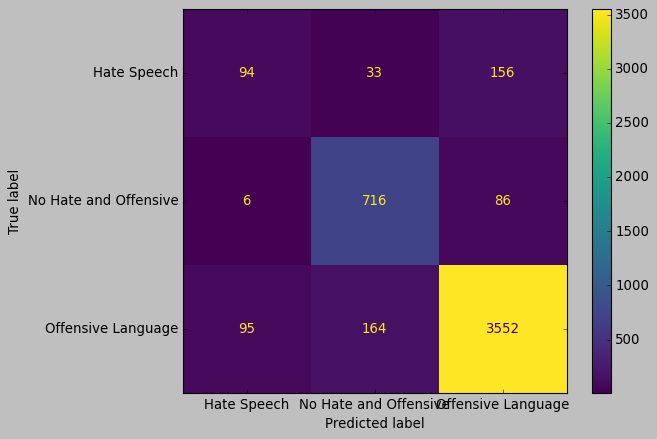

In [30]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [31]:
new_row = {'Model': 'Logistic Regression', 'Accuracy': logreg_acc}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [32]:
#for performing hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [33]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(X_train_resampled, y_train_resampled)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.98
Best parameters:  {'C': 100, 'solver': 'newton-cg'}


In [34]:
log_grid_pred = grid.predict(X_test)

In [35]:
log_grid_acc = accuracy_score(log_grid_pred, Y_test)
print("Test accuracy: {:.2f}%".format(log_grid_acc*100))

Test accuracy: 89.49%


In [36]:
print(confusion_matrix(Y_test, log_grid_pred))
print("\n")
print(classification_report(Y_test, log_grid_pred))

[[  52   24  207]
 [   4  672  132]
 [  37  111 3663]]


                       precision    recall  f1-score   support

          Hate Speech       0.56      0.18      0.28       283
No Hate and Offensive       0.83      0.83      0.83       808
   Offensive Language       0.92      0.96      0.94      3811

             accuracy                           0.89      4902
            macro avg       0.77      0.66      0.68      4902
         weighted avg       0.88      0.89      0.88      4902



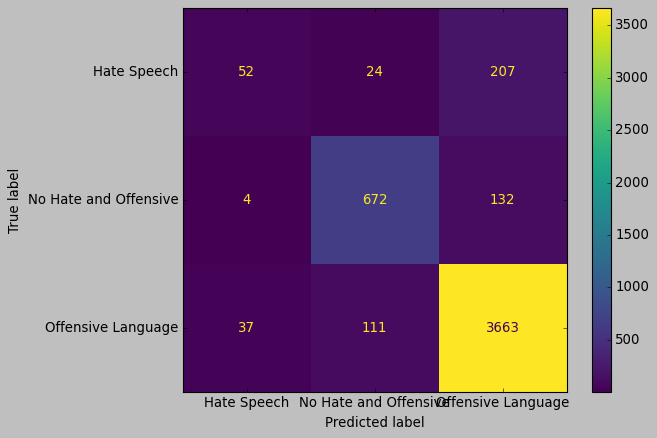

In [37]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, log_grid_pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()

In [38]:
new_row = {'Model': 'Logistic Regression Tuned', 'Accuracy': log_grid_acc}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [39]:
#for training the data on decision tree classifier model
dtree = DecisionTreeClassifier()
dtree.fit(X_train_resampled, y_train_resampled) #loading x_train and y_train data on model
dtree_predict = dtree.predict(X_test) #predicting the value for test data
dtree_acc = accuracy_score(dtree_predict, Y_test)

In [40]:
print("Test accuracy: {:.2f}%".format(dtree_acc*100)) 

Test accuracy: 86.66%


In [41]:
print(confusion_matrix(Y_test, dtree_predict))
print("\n")
print(classification_report(Y_test, dtree_predict))

[[ 112   35  136]
 [  16  705   87]
 [ 198  182 3431]]


                       precision    recall  f1-score   support

          Hate Speech       0.34      0.40      0.37       283
No Hate and Offensive       0.76      0.87      0.82       808
   Offensive Language       0.94      0.90      0.92      3811

             accuracy                           0.87      4902
            macro avg       0.68      0.72      0.70      4902
         weighted avg       0.88      0.87      0.87      4902



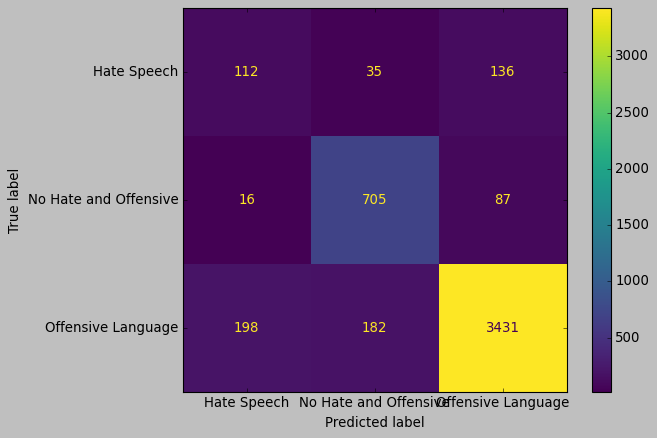

In [42]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, dtree_predict, labels=dtree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtree.classes_)
disp.plot()

In [43]:
new_row = {'Model': 'Decision Tree Classifier', 'Accuracy': dtree_acc}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [44]:
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train_resampled, y_train_resampled)
clf_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(clf_pred, Y_test)

In [45]:
print("Test accuracy: {:.2f}%".format(clf_accuracy*100)) 

Test accuracy: 87.11%


In [46]:
print(confusion_matrix(Y_test, clf_pred))
print("\n")
print(classification_report(Y_test, clf_pred))

[[  60   22  201]
 [  10  596  202]
 [  68  129 3614]]


                       precision    recall  f1-score   support

          Hate Speech       0.43      0.21      0.29       283
No Hate and Offensive       0.80      0.74      0.77       808
   Offensive Language       0.90      0.95      0.92      3811

             accuracy                           0.87      4902
            macro avg       0.71      0.63      0.66      4902
         weighted avg       0.86      0.87      0.86      4902



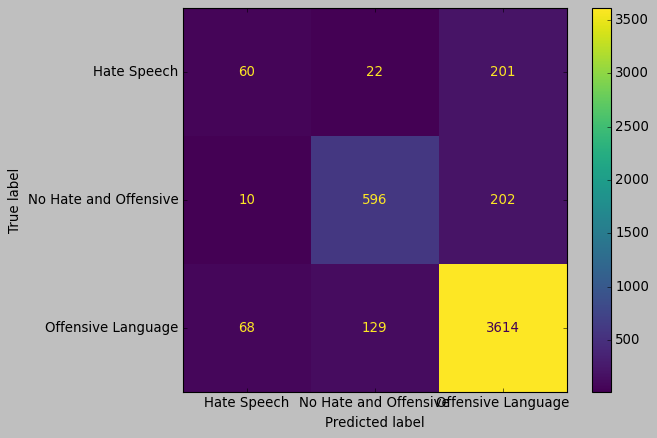

In [47]:
style.use('classic')
cm = confusion_matrix(Y_test, clf_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [48]:
new_row = {'Model': 'Random Forest Classifier', 'Accuracy': clf_accuracy}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [49]:
AMD = AdaBoostClassifier(n_estimators=100)
AMD.fit(X_train_resampled, y_train_resampled)
AMD_pred = AMD.predict(X_test)
AMD_accuracy = accuracy_score(Y_test, AMD_pred)

In [50]:
print("Test accuracy: {:.2f}%".format(AMD_accuracy*100)) 

Test accuracy: 84.94%


In [51]:
print(confusion_matrix(Y_test, AMD_pred))
print("\n")
print(classification_report(Y_test, AMD_pred))

[[ 122   51  110]
 [  13  775   20]
 [ 226  318 3267]]


                       precision    recall  f1-score   support

          Hate Speech       0.34      0.43      0.38       283
No Hate and Offensive       0.68      0.96      0.79       808
   Offensive Language       0.96      0.86      0.91      3811

             accuracy                           0.85      4902
            macro avg       0.66      0.75      0.69      4902
         weighted avg       0.88      0.85      0.86      4902



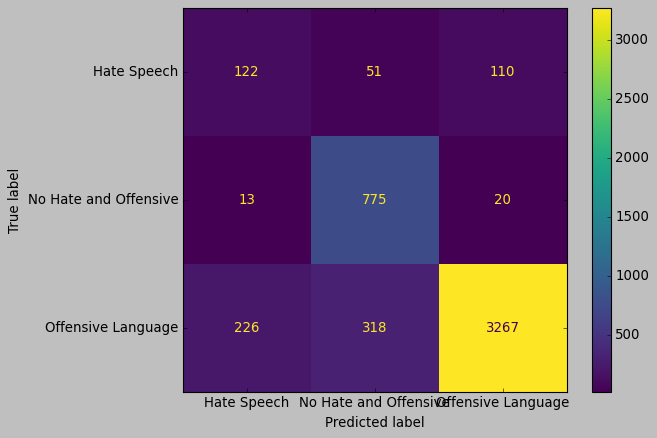

In [52]:
style.use('classic')
cm = confusion_matrix(Y_test, AMD_pred, labels=AMD.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=AMD.classes_)
disp.plot()

In [53]:
new_row = {'Model': 'AdaBoostClassifier', 'Accuracy': AMD_accuracy}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [54]:
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_pred = AMD.predict(X_test)
svm_accuracy = accuracy_score(Y_test, svm_pred)

In [55]:
print("Test accuracy: {:.2f}%".format(AMD_accuracy*100)) 

Test accuracy: 84.94%


In [56]:
new_row = {'Model': 'SVC', 'Accuracy': svm_accuracy}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [57]:
print(confusion_matrix(Y_test, svm_pred))
print("\n")
print(classification_report(Y_test, svm_pred))

[[ 122   51  110]
 [  13  775   20]
 [ 226  318 3267]]


                       precision    recall  f1-score   support

          Hate Speech       0.34      0.43      0.38       283
No Hate and Offensive       0.68      0.96      0.79       808
   Offensive Language       0.96      0.86      0.91      3811

             accuracy                           0.85      4902
            macro avg       0.66      0.75      0.69      4902
         weighted avg       0.88      0.85      0.86      4902



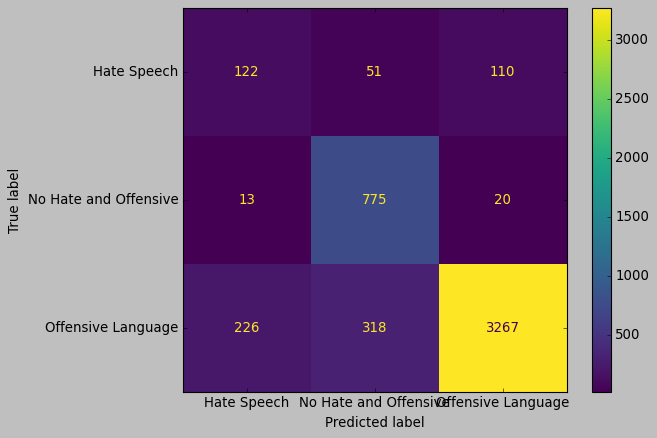

In [58]:
style.use('classic')
cm = confusion_matrix(Y_test, svm_pred, labels=svm_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()

In [59]:
from sklearn.naive_bayes import GaussianNB

In [63]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Load the data
df = pd.read_csv('labeled_data.csv')
text = df['tweet'].tolist()
clas = df['class'].tolist()

# Split the data into features (X) and labels (y)
X = text
y = clas

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert the sparse matrix to a dense NumPy array
X_train_resampled_dense = X_train_resampled.toarray()

# Train a Gaussian Naive Bayes classifier on the resampled data
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_resampled_dense, y_train_resampled)

# Convert the test set to a dense array
X_test_dense = X_test.toarray()

# Make predictions on the test set
nb_predict = nb_classifier.predict(X_test_dense)

# Evaluate the classifier
nb_acc = accuracy_score(y_test, nb_predict)
print("Accuracy:", nb_acc)
print("\nClassification Report:\n", classification_report(y_test, nb_predict))

Accuracy: 0.5634456324389752

Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.29      0.12       290
           1       0.83      0.59      0.69      3832
           2       0.40      0.52      0.45       835

    accuracy                           0.56      4957
   macro avg       0.43      0.47      0.42      4957
weighted avg       0.71      0.56      0.62      4957



nb_classifier = GaussianNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)
nb_predict = nb_classifier.predict(X_test)
nb_acc = accuracy_score(Y_test , nb_predict)

In [64]:
print("Test accuracy: {:.2f}%".format(nb_acc*100)) 

Test accuracy: 56.34%


In [65]:
new_row = {'Model': 'Naive Bayes', 'Accuracy': nb_acc}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

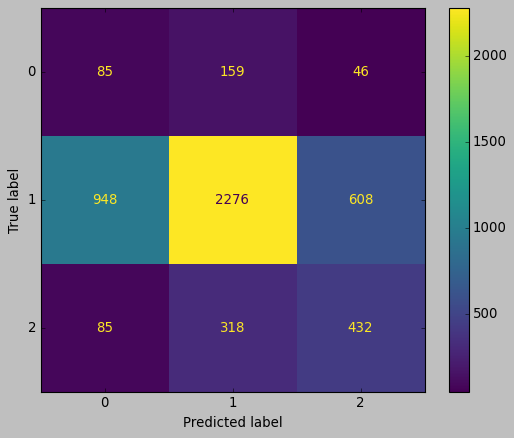

In [68]:
style.use('classic')
cm = confusion_matrix(y_test, nb_predict, labels=nb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_classifier.classes_)
disp.plot()

In [69]:
df = pd.read_csv('labeled_data.csv')

In [70]:
text = df['tweet'].tolist()
clas = df['class'].tolist()

In [71]:
df = pd.DataFrame({'tweet': text, 'class': clas})

In [72]:
df['tweet'] = df['tweet'].apply(lambda x:x.lower())

In [73]:
punctuation_signs = list("?:!.,;")
df['tweet'] = df['tweet']

for punct_sign in punctuation_signs:   
    df['tweet'] = df['tweet'].str.replace(punct_sign, '')

In [74]:
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("'s", "")

In [75]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yashp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
cv = CountVectorizer(max_features = 75)
X = cv.fit_transform(df['tweet']).toarray()
y = df['class']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [78]:
y_train=to_categorical(y_train, num_classes = 3, dtype='float32')
y_test=to_categorical(y_test, num_classes = 3, dtype='float32')

In [79]:
from keras.utils import to_categorical

# Assuming y_train and y_test are integer labels
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [80]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))  # Change the number of units to 3 for three classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use categorical_crossentropy for multi-class problems

In [81]:
epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
310/310 [==============================] - 83s 251ms/step - loss: 0.8692 - accuracy: 0.6566 - val_loss: 0.6665 - val_accuracy: 0.7743
Epoch 2/10
310/310 [==============================] - 77s 249ms/step - loss: 0.6859 - accuracy: 0.7730 - val_loss: 0.6633 - val_accuracy: 0.7743
Epoch 3/10
310/310 [==============================] - 77s 249ms/step - loss: 0.6687 - accuracy: 0.7744 - val_loss: 0.6657 - val_accuracy: 0.7743
Epoch 4/10
310/310 [==============================] - 79s 255ms/step - loss: 0.6704 - accuracy: 0.7742 - val_loss: 0.6682 - val_accuracy: 0.7743
Epoch 5/10
310/310 [==============================] - 85s 273ms/step - loss: 0.6623 - accuracy: 0.7743 - val_loss: 0.6642 - val_accuracy: 0.7743
Epoch 6/10
310/310 [==============================] - 78s 251ms/step - loss: 0.6591 - accuracy: 0.7743 - val_loss: 0.6625 - val_accuracy: 0.7743
Epoch 7/10
310/310 [==============================] - 81s 260ms/step - loss: 0.6599 - accuracy: 0.7743 - val_loss: 0.6644 - val_ac

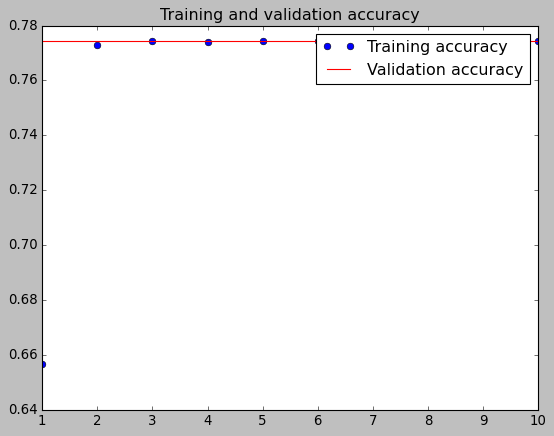

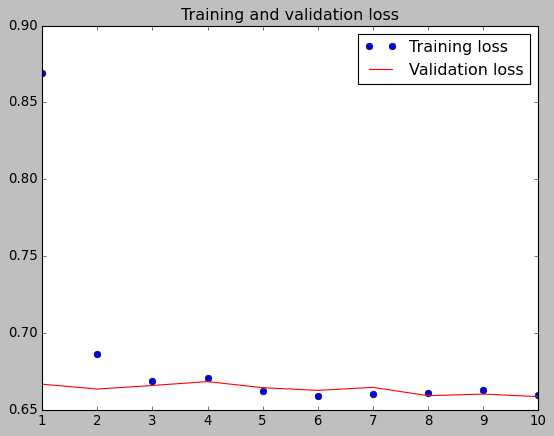

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [83]:
new_row = {'Model': 'LSTM', 'Accuracy': acc[-1]}
acc_summary=pd.concat([acc_summary, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [84]:
print(acc_summary)

                       Model  Accuracy
0        Logistic Regression  0.889841
1  Logistic Regression Tuned  0.894941
2   Decision Tree Classifier  0.866585
3   Random Forest Classifier  0.871073
4         AdaBoostClassifier  0.849449
5                        SVC  0.849449
6                Naive Bayes  0.563446
7                       LSTM  0.774337
